In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from src.utils import pie_plot


In [2]:
df = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')

## Basic overview

In [3]:
print(f'This dataset contains {df.shape[0]} samples and {df.shape[1]} features')

This dataset contains 6362620 samples and 11 features


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Observations:

- Step: based on the mean and the std deviation, the distribution seems quite uniform.

- Amount: there is an enormous variation of amount of transferred money and the standard deviation is very high (603.858). 
50% of all transactions move below 74.872, 75% of all transactions move below 208.721 and the max amount is 92.445.200 so we will find very few but huge transactions (long tail).

- OldbalanceOrg, NewbalanceOrig, OldbalanceDest and NewbalanceDest: both have similar standard deviations and maximum values. It calls my attention that min, 25% and even 50% can be 0. That makes me wonder if those accounts have been opened or closed just to commit fraud. Some significant amount accounts have also completely completely emptied. 

- isFraud: the mean is very close to zero so we can expect the labels of fraudulent transactions are going to be rare and the dataset unbalanced. 

- isFlaggedFraud: the mean is even lower but we have to take into consideration that this flag is activated only for transactions greater than 200.000. 

In [7]:
df.describe(include = ['O'])

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1530544995,C1286084959
freq,2237500,3,113


Observations:

- Type: there are 5 types of transactions, the most frequent is CASH_OUT. We will analyse them and their relationship with fraudulent transactions.

- nameOrig and nameDest: some names are repeated. We will check if that has something to do with fraudulent behaviours. 

## Data preparation

In [8]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

We won't use the column 'isFlaggedFraud' for now

In [9]:
data = df[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].copy()

In [10]:
data = data.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [11]:
data.loc[data.duplicated()]

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud


## Visualization of variables

### Target variable: isFraud

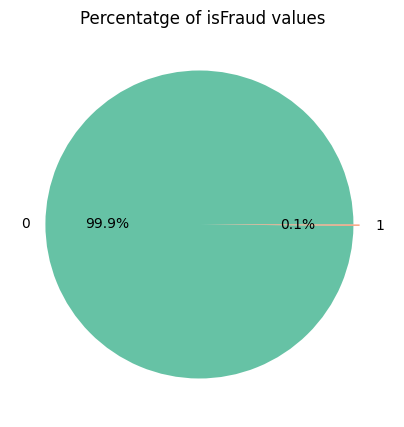

In [12]:
pie_plot(df['isFraud'])


In [13]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

This is an extremely imbalanced dataset

### Numerical features

KeyError: 'oldbalanceOrig'

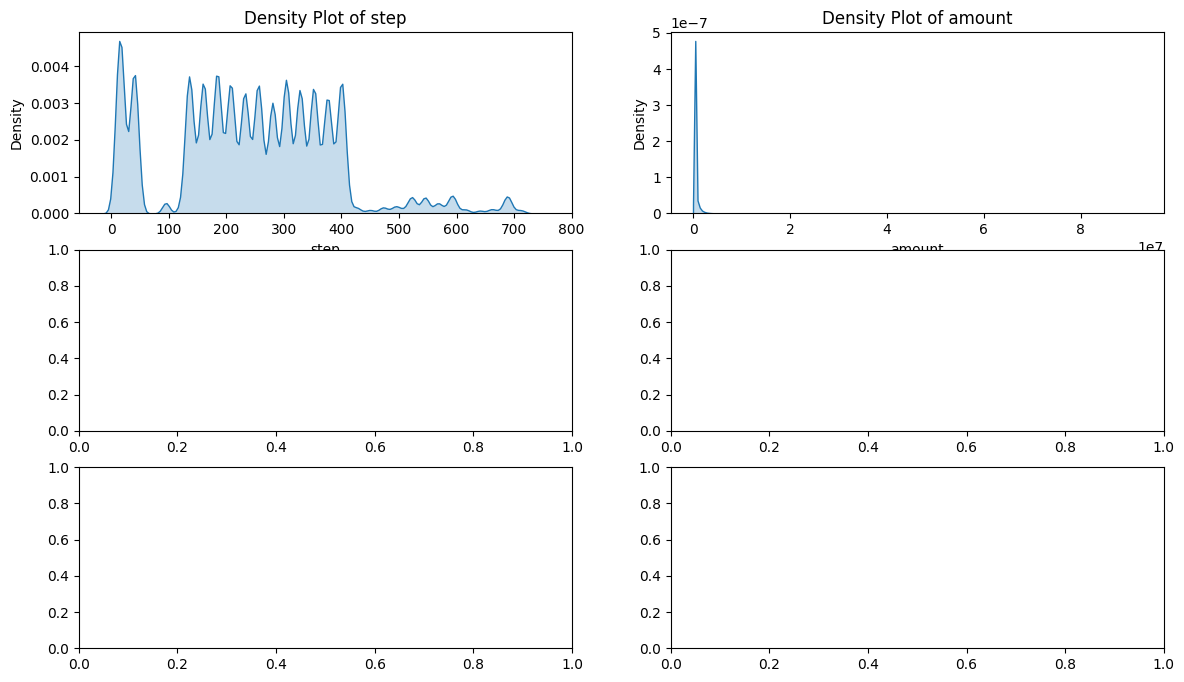

In [14]:
numeric_cols =['step', 'amount','oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest','newbalanceDest']


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,8))
axes = axes.flatten()  

for ax, col in zip(axes, numeric_cols):
    sns.kdeplot(df[col], ax=ax, fill=True)
    ax.set_title(f'Density Plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
data.loc[df.duplicated(subset ='nameOrig')]

In [ ]:
data.query('nameOrig == "C850961884"')

In [ ]:
data.loc[data.duplicated(subset =['nameOrig', 'nameDest'])]

Ideas:

- Check duplicated with query on names orig and dest that are Fraud == 1